# Detecting Drift in Text Data

Here, we load the civilcomments dataset; a dataset of comments from the Civil Comments platform. The dataset is available on [Kaggle](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data). We use the prepackaged loaders in the WILDS library to load the dataset.

In [1]:
!pip install wilds --quiet

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from gate import summarize, detect_drift
from wilds import get_dataset

import numpy as np
import os
import pandas as pd

/Users/shreyashankar/miniforge3/envs/dataval/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
raw_dataset = get_dataset(
    dataset="civilcomments", download=True, root_dir="data"
)
df = pd.read_csv(
    os.path.join(
        "data", "civilcomments_v1.0", "all_data_with_identities.csv"
    )
)
# df["created_date"] = pd.to_datetime(df["created_date"], format='mixed')

# Sample 10,000 rows from the dataset
df = df.sample(n=20000, random_state=42).reset_index(drop=True)

To create partitions, we can look at the toxicity levels of the comments.

<Axes: >

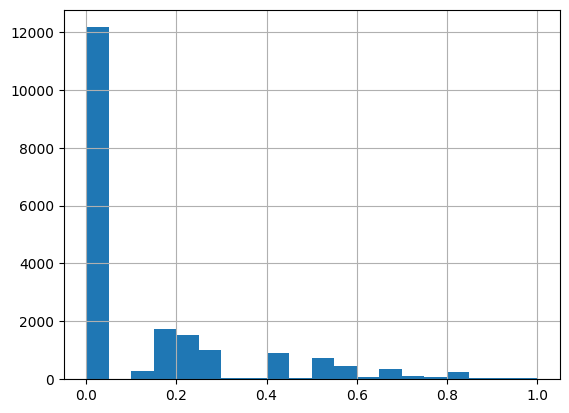

In [5]:
df["toxicity"].hist(bins=20)

We'll create 10 partitions; one with low toxicity levels, one with high toxicity levels, and the other 8 with a random mix of toxicity levels.

In [6]:
def assign_partition(toxicity):
    if toxicity < 0.1:
        return "9_low"
    elif toxicity > 0.9:
        return "9_high"
    else:
        i = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8])
        return f"{i}_medium"

df["partition"] = df["toxicity"].apply(assign_partition)
df.head()

,Unnamed: 0,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,...,disability_any,identity_any,num_identities,more_than_one_identity,na_gender,na_orientation,na_religion,na_race,na_disability,partition
0,315698,5041802,"Thank you Stephanie, great post. You should be...",train,2017-03-23 02:09:07.887924+00,55,NaN,320734,approved,0,...,0,0,0.0,False,1,1,1,1,1,9_low
1,205291,5924876,"Poor, poor us! We're so abused! Give it a brea...",train,2017-09-09 14:08:31.131728+00,54,5923381.0,375645,rejected,0,...,0,1,1.0,False,0,1,1,1,1,2_medium
2,98697,5926727,"Yeah, as we've gotten so used to with the Rock...",train,2017-09-09 20:35:55.150162+00,102,5924578.0,375714,approved,0,...,0,0,0.0,False,1,1,1,1,1,9_low
3,42002,5785459,"If your actions thereby assist Sears' failure,...",test,2017-08-17 04:15:42.186750+00,54,5785299.0,367422,approved,0,...,0,0,0.0,False,1,1,1,1,1,9_low
4,385519,5240478,"It is indeed a balancing act, but by supportin...",train,2017-05-10 22:34:47.727569+00,53,5238832.0,333501,approved,0,...,0,1,2.0,True,0,1,0,1,1,7_medium


## Create Embeddings

For the `comment_text` column, we create embeddings using the huggingface `sentence-transformers` library.

In [7]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
comments = df["comment_text"].tolist()
embeddings = model.encode(comments, show_progress_bar=True)

Batches: 100%|██████████| 625/625 [02:31<00:00,  4.14it/s]


In [8]:
df["comment_embedding"] = [e for e in embeddings]

## Create Partition Summaries

We use the `summarize` function to create partition summaries for each partition. We use the `comment_text` column as the embedding key, and the `comment_embedding` column as embedding value. We also pass in other columns that we want to compute statistics for.

In [9]:
columns = [
    "rating",
    "toxicity"
]
partition_key = "partition"
embedding_key = "comment_text"
embedding_value = "comment_embedding"


In [10]:
summaries = summarize(df, columns, partition_key=partition_key, embedding_column_map={embedding_key: embedding_value})
print(f"Computed summaries for {len(summaries)} partitions.")

Computed summaries for 10 partitions.


We can print out the summary of the first partition:

In [11]:
print(summaries[0])

Regular summary:
  partition    column  coverage      mean  num_unique_values  occurrence_ratio  p50       p95
0  1_medium    rating       1.0       NaN                2.0          0.881002  NaN       NaN
1  1_medium  toxicity       1.0  0.342472                NaN               NaN  0.3  0.790323
Embedding summary:
    partition                 column  coverage          mean           p50           p95
0    1_medium    comment_embedding_0       1.0  2.915310e-02  2.998098e-02  1.070179e-01
1    1_medium    comment_embedding_1       1.0  1.808381e-02  1.903583e-02  1.030365e-01
2    1_medium   comment_embedding_10       1.0  2.155384e-04 -9.552613e-04  8.198688e-02
3    1_medium  comment_embedding_100       1.0 -3.394470e-02 -3.461882e-02  3.908946e-02
4    1_medium  comment_embedding_101       1.0  1.424212e-02  1.241668e-02  9.585363e-02
5    1_medium  comment_embedding_102       1.0 -6.614123e-03 -6.704919e-03  6.507558e-02
6    1_medium  comment_embedding_103       1.0 -1.635480e-0

## Compute Drift

For each partition after the first 5 partitions, we compute the drift between the partition and historical partitions.

In [12]:
partition_names = [s.partition for s in summaries]

In [13]:
drifted_partitions = {}

for i in range(len(summaries)-2, len(summaries)):
    print(f"Checking partition {partition_names[i]}...")
    drift_results = detect_drift(summaries[i], summaries[:i])    
    if drift_results.score_percentile > 0.85: # We use this instead of is_drifted since is_drifted's threshold is 95th percentile, and we want to be less strict since we only have 10 partitions
        print(f"Drift detected in partition {partition_names[i]}!")
        drifted_partitions[partition_names[i]] = drift_results

Checking partition 9_high...
Drift detected in partition 9_high!
Checking partition 9_low...
Drift detected in partition 9_low!


## Inspect Drift Results

For the high and low toxicity partitions, we can print out the top drifted columns and drift score.

In [14]:
def get_summary(partition_name):
    for summary in summaries:
        if summary.partition == partition_name:
            return summary
    return None


partition_name = list(drifted_partitions.keys())[0]
print(partition_name)
drift_results_high = drifted_partitions[partition_name]
print(drift_results_high)

9_high
Drift score: 78.3159 (100.00% percentile)
Top drifted columns:
                          statistic   z-score
column                                       
toxicity                        p50  2.666667
rating             occurrence_ratio -2.644178
comment_embedding              mean  1.909929


In [15]:
partition_name = list(drifted_partitions.keys())[1]
print(partition_name)
drift_results_low = drifted_partitions[partition_name]
print(drift_results_low)

9_low
Drift score: 57.4154 (88.89% percentile)
Top drifted columns:
                          statistic   z-score
column                                       
toxicity                        p95 -2.716521
comment_embedding              mean  1.415445
rating             occurrence_ratio  1.197798


### Look at Drifted Embeddings for High Toxicity Partition

In the drifted partition, we can identify the cluster of embeddings that diverged most from its values in historical partitions.

`drifted_examples` represents the examples in the drifted partition. `corresponding_examples` represents the examples in the historical partitions.

In [16]:
result = drift_results_high.drifted_examples("comment_text")
drifted_examples = result["drifted_examples"]
corresponding_examples = result["corresponding_examples"]

In [17]:
drifted_examples[embedding_key].to_list()

['Many bishops running the church now were elevated by a man so depraved and perverse he spent decades protecting child rapists internationally.  And they deified him when he finally died.  They are sick and twisted and are led by a sick and twisted little man masquerading as a saint.',
 'This bible thumping imbecile is a disgrace to Indiana my home state.  He signed a so-called "Religious Freedom" bill that almost killed Indianapolis\' large convention business until it was repealed.  Senator Corker can add one more to the "White House Adult Daycare" roster.',
 'Lord, what a tedious, tiresome, transparently deceptive and misleading troll you are.  Are you so delusional that you cannot see by the reactions of other posters that nobody is buying your repetitive and specious spins?  Obviously, Cassie (or whomever you are) your only recourse here is to go on the offensive and attack the reporters and the opposition with blatant lies and misleading out of context drive by smears.  You are 

In [18]:
corresponding_examples[embedding_key].to_list()

['And by the way, there is no "Palestinian" land, as there are no Palestinians - they are Jordanians and Egyptians, who were not welcomed in either country, huddled under an umbrella and named Palestinians by the terrorist Arafat, who cleverly realized that he\'d get no traction for his cause of pushing every Jew into the sea in favour of "displaced" Arab Muslims that their home countries didn\'t want.',
 'That was the critical difference between Trump\'s ban on 6 countries and Obama\'s list of 7 countries for vetting people from all countries who may have visited any of the 7 countries. But Obama did not have a complete ban on any countries and that plus the statements that we were going to ban Muslims and Muslim countries from coming to the US. That is why Trump\'s ban ran into constitutional issues-- he could have just had a vetting list instead of a total van on everyone from a country. Also remember that the Court ordered "block" on the van is only temporary until the actual case 

It looks like the Trump-related comments have drifted to be more toxic!

We can do the same thing from the low toxicity partition. But the results don't make as much sense here.

In [19]:
result = drift_results_low.drifted_examples("comment_text")
drifted_examples = result["drifted_examples"]
corresponding_examples = result["corresponding_examples"]

In [20]:
drifted_examples[embedding_key].to_list()

['Yes. "We need more facts, less extreme vetting."  And part of any call for more fact-based public discourse should involve de-emphasizing public image, glamour, and so on since these things distract from the facts.\n\nSo maybe M.H. could ease up on the image game and the personal branding? The hair, the outfits, oy vey.  It\'s a distraction, self-centered, irrelevant to the issues she discusses and the cases she\'s involved in.  Vapid image culture is one of the reasons we end up with the Trump\'s and O\' Leary\'s. Their brands are known. It\'s tiresome.',
 'I agree, there are others...Bernie Madoff, Leona Hemsley, El Chapo, Pablo Escobar,\nSatan, Idi Amin, Putin, Duarte, and the grinch who stole Christmas.',
 "So God hasn't abandoned us and we can of our own volition to return to Him. That doesn't mean we won't reap the consequences of our foolish political decisions and live through a time that that will cause many in the nation to reevaluate their abandonment of God's way of doing

In [21]:
corresponding_examples[embedding_key].to_list()

['Adultery as defined by Jesus is in the Decalogue. \n\nSome rigorists and legalists are forever defining down the Word of God, which is the whole of the Bible. \n\nThe error runs like this:\n\nbut where is that in the Scripture?\nbut the old testament is "old" and as everyone knows has been replaced by the new testament; so where in the new testament is that said?\nbut much of the new testament was written by people who never knew Jesus\nso where in the Gospels is that said?\nbut we don\'t really know who wrote all the gospels\nso where did Jesus Himself say that....precisely that?',
 'Has Trudeau asked the leaders of other denominations, or are only Catholics guilty?',
 'Pope Francis has been pretty awful on women.  It is clear he has the same old fashioned attitudes about women that his predecessors have, especially with his weird fixation on "gender theory" and "gender ideology."  Women may be valuable in sprinkling mommy dust over the society and should be included because of that